### Goal
Implement a neural network model using the individual and gene effect information.

### TODO
 - 1. Gene effect variation using PCA 
     - variance explained of the PCA
     - recovery blood expression data from PCA 
 - 2. Autoencoder for individual effect

### Conclusions
 - 1. 1024 components explain 97\% of the gene effect variation over tissues
 - 2. 

In [2]:
import os

import comet_ml
import numpy as np
import pandas as pd

import keras
from keras import backend as K
from keras.layers import Input, Dense, Add, Dropout, Embedding, Conv2D, Flatten, Conv1D, MaxPooling1D, LeakyReLU
from keras.models import Sequential

from keras.models import Model
from keras.losses import *
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.regularizers import *

import warnings; warnings.simplefilter('ignore')

import rep.preprocessing_new as prep
import rep.datasets as d
import rep.models as m
import rep.metrics as mt

import matplotlib.pyplot as plt
%matplotlib inline
%autoreload 1

from tensorflow.python.client import device_lib
import tensorflow as tf

# import keras
# from keras import backend as K

from numpy.random import seed
seed(1)

# from tensorflow import keras
# from tensorflow.keras import backend as K
# from tensorflow.keras.layers import *

# from tensorflow.keras.models import Model, Sequential
# from tensorflow.keras.losses import *
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.regularizers import *

In [3]:
config = tf.ConfigProto( device_count = {'GPU': 1, 'CPU': 4} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

In [4]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10240851666335420714
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 2223834963409278768
physical_device_desc: "device: XLA_CPU device"
]


In [4]:
data_path = os.readlink(os.path.join("..","..","data"))
path = os.path.join(data_path,"processed","gtex")
x_inputs_h5 = os.path.join(path,"X_inputs_pc_onlyblood.h5")
y_targets_h5 = os.path.join(path,"Y_targets_pc_onlyblood.h5")
train_raw, valid_raw = d.rep_blood_expression(x_inputs_h5, y_targets_h5, label=None)

### 1. Gene effect variation using PCA

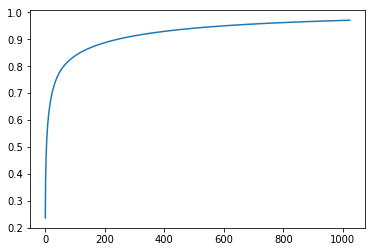

In [7]:
# compute PCA for gene effect variation
from sklearn.decomposition import PCA
nComp = 1024
pca = PCA(n_components=nComp)
data_train = np.concatenate((train_raw.inputs.T, train_raw.targets.T), axis=1)
data_valid = np.concatenate((valid_raw.inputs.T, valid_raw.targets.T), axis=1)
gene_effect = pca.fit_transform(data_train)

# reconstruct Gene Effect
mu = np.mean(data_train, axis=0)
gene_effect_pred = np.dot(pca.transform(data_train)[:,:nComp], pca.components_[:nComp,:])
gene_effect_pred += mu

eval_gene_effect = mt.rep_metric(data_train, gene_effect_pred)
eval_gene_effect['spearmanr']

# plot cumsum of the effect
plt.plot(np.cumsum((pca.explained_variance_ratio_)))

In [8]:
print("Variance explained",np.max(np.cumsum((pca.explained_variance_ratio_))))

Variance explained 0.970557


In [5]:
# filter train and valid by tissue
train = train_raw.filter_by(from_tissue='Whole Blood',to_tissue='Muscle - Skeletal')
valid = valid_raw.filter_by(from_tissue='Whole Blood',to_tissue='Muscle - Skeletal')
del train_raw, valid_raw

In [7]:
train.inputs.shape, train.targets.shape, train.metadata.shape, train.features.shape

((220, 19932), (220, 19932), (220, 11), (19932, 3))

### 2.1. Autoencoder for individual effect

In [14]:
from sklearn.utils.validation import check_array as check_arrays

# loss
def mean_absolute_percentage_error(y_true, y_pred): 
    return K.mean(K.abs((y_true - y_pred) / y_true)) * 100

def huber_loss(y_true, y_pred, clip_delta=2.5):
    error = y_true - y_pred
    cond  = tf.keras.backend.abs(error) < clip_delta

    squared_loss = 0.5 * tf.keras.backend.square(error)
    linear_loss  = clip_delta * (tf.keras.backend.abs(error) - 0.5 * clip_delta)

    return tf.where(cond, squared_loss, linear_loss)


# optimizer
adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.0000001)

# autoencoder
code_size = 64
ae = Sequential([
    Dense(code_size, input_shape=(train.inputs.shape[1],)),
    Dense(train.inputs.shape[1])
])
ae.compile(optimizer = adam, 
           loss = 'mean_squared_error')

ae.fit(train.inputs,
       train.inputs,
       epochs=500,
       batch_size=16,
       validation_data=(valid.inputs, valid.inputs),
       verbose=0,
       callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.000001, patience=5)])

recovered_data = ae.predict(valid.inputs)
eval_ae = mt.rep_metric(valid.inputs, recovered_data)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


In [15]:
eval_ae['spearmanr']

{'mean': 0.7630303126163696,
 'min': -0.40711153704414127,
 'p10': 0.2063174937062444,
 'p25': 0.6632380626847383,
 'median': 0.9252915184147276,
 'p75': 0.9689799217019847,
 'p90': 0.9805409490223241,
 'max': 0.9945212380742464}

### 3. Neural network - implement gene expression imputation from blood to muscle tissue

#### 3.1 Implement a network with one layer to predict from blood to muscle

In [19]:
hidden = 64
nn = Sequential([
    Dense(hidden, input_shape=(train.inputs.shape[1],)),
    Dense(train.inputs.shape[1])
])
nn.compile(optimizer = adam, 
           loss = 'mean_squared_error')
nn.reset_states()
nn.fit(train.inputs,
       train.targets,
       epochs=500,
       batch_size=16,
       validation_data=(valid.inputs, valid.targets),
       verbose=0,
       callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.000001, patience=5)])
recovered_data = nn.predict(valid.inputs)
eval_nn = mt.rep_metric(valid.targets, recovered_data)
eval_nn['spearmanr']

{'mean': 0.32708409937405153,
 'min': -0.4964952687755446,
 'p10': 0.015261935930561157,
 'p25': 0.16836818324962177,
 'median': 0.34903650372417216,
 'p75': 0.49716618739487645,
 'p90': 0.60299649450203,
 'max': 0.8727828040531936}

#### 3.1.1 Add layers

In [76]:
np.random.seed(1337)
# optimizer
adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.0000001)

def simple_model():
    
    hidden = 1024
    hidden_2 = 256
    hidden_3 = 64
    hidden_4 = 32
    
    nn_aux = Sequential([
        Dense(hidden, input_shape=(train.inputs.shape[1],)),
        Dense(hidden_2),
        Dense(hidden_3),
        Dense(hidden_4),
        Dense(train.inputs.shape[1])
    ])
    nn_aux.compile(optimizer = adam, 
               loss = 'mean_squared_error')

    return nn_aux

In [77]:
nn = simple_model()

In [78]:
nn.reset_states()
nn.fit(train.inputs,
       train.targets,
       epochs=500,
       batch_size=16,
       validation_data=(valid.inputs, valid.targets),
       verbose=0,
       callbacks=[EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=5)])
recovered_data = nn.predict(valid.inputs)
eval_nn = mt.rep_metric(valid.targets, recovered_data)
eval_nn['spearmanr']

{'mean': 0.29230391734801814,
 'min': -0.40162066413046044,
 'p10': -0.008554778273798682,
 'p25': 0.12727561228072834,
 'median': 0.30400512187068746,
 'p75': 0.457812926409061,
 'p90': 0.5804582380302498,
 'max': 0.861583996353003}

In [67]:
nn.save("simple_layer_model.h5")

#### 3.2 Network 
- contains the AE hidden layer of the individual variation as first layer

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(1234)

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

hidden = 128
hidden_2 = 64
hidden_3 = 32

x = torch.tensor(train.inputs)
y = torch.tensor(train.targets)
model = nn.Sequential(
                    nn.Linear(train.inputs.shape[1],hidden),
                    nn.Conv1d(hidden,1,3,stride=1),
                    nn.Conv1d(10,10,3,stride=2,dilation=2),
                    nn.Conv1d(10,10,3,stride=4,dilation=4)\
#     ,
#                     Flatten(),
#                     nn.Linear(hidden, train.inputs.shape[1])
                    )
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=0.0000001)


for epoch in range(500):
    # Forward Propagation
    y_pred = model(x)
    print(y_pred.shape)
    # Compute and print loss
    loss = criterion(y_pred, y)
    
    if epoch % 50 == 0:
        print('epoch: ', epoch,' loss: ', loss.item())
    
    # Zero the gradients
    optimizer.zero_grad()
    
    # perform a backward pass (backpropagation)
    loss.backward()
    
    # Update the parameters
    optimizer.step()

x_valid = torch.tensor(valid.inputs)
y_valid = torch.tensor(valid.targets)

y_pred = model(x_valid)
eval_nn = mt.rep_metric(valid.targets, y_pred.detach().numpy())
eval_nn['spearmanr']

In [9]:
import torch
import pycuda.driver as cuda

cuda.init()

## Get Id of default device
torch.cuda.current_device()
# 0
cuda.Device(0).name()

In [16]:
weights_autoencoder = ae.layers[0].get_weights()

In [10]:
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

# optimizer
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.0000001)

def model_conv():
    
    hidden = 128
    hidden_2 = 64
    hidden_3 = 32  
    
    input1 = keras.layers.Input(shape=(train.inputs.shape[1],1))
    hidden1 = keras.layers.Dense(hidden)(input1)
    hidden2 = keras.layers.Conv1D(3, (3), strides=1, padding='valid')(hidden1)
    hidden3 = keras.layers.Conv1D(3, (3), dilation_rate = 2, padding='valid')(hidden2)
    flat = keras.layers.Flatten()(hidden3)
    outh = keras.layers.Dense(train.inputs.shape[1])(flat)
    
    nn_aux = keras.models.Model(inputs=input1, outputs=outh)
    nn_aux.compile(optimizer = adam, 
               loss = 'mean_squared_error')
    
    return nn_aux

In [ ]:
nn = model_conv()
nn.reset_states()
nn.fit(K.expand_dims(train.inputs),
       train.targets,
       epochs=10,
#        batch_size=16,
       steps_per_epoch=16,
       validation_steps=16,
       validation_data=(K.expand_dims(valid.inputs), valid.targets),
       verbose=0,
       callbacks=[
           EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5), 
           plot_losses])

Instructions for updating:
Use tf.cast instead.


In [1]:
y_pred = nn.predict(K.expand_dims(valid.inputs))
eval_nn = mt.rep_metric(valid.targets, y_pred)
eval_nn['spearmanr']

NameError: name 'nn' is not defined

In [24]:
# hidden = 256
# hidden_2 = 128
# hidden_3 = 32
# hidden_4 = 16
# # hidden_2 = 1024
# nn = Sequential([
#     Dense(code_size, input_shape=(train.inputs.shape[1],), trainable=False),
#     Dense(hidden_2),
#     Dense(hidden_3),
#     Dense(hidden_4),
#     Dense(train.inputs.shape[1])
# ])
    
    
#     Dropout(0.1),
#     Dense(hidden_2),
#     Dropout(0.1),
#     Conv1D(filters=16, kernel_size=(3), activation='relu', input_shape=(hidden_2,1)),
#     MaxPooling1D(pool_size=2),
#     Flatten(),
#     Dense(train.inputs.shape[1])
# ])

TensorShape([Dimension(None), Dimension(19932)])

In [ ]:
print(nn.summary())